Elaboration of data output from SQL database

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import re
import numpy as np

In [4]:
# Importing from esm database.db
conn = sqlite3.connect('database.db')
query_cost_op_tot = "SELECT * FROM cost_op_tot"  
cost_op_tot = pd.read_sql_query(query_cost_op_tot, conn)
query_cost_period = "SELECT * FROM cost_period"
cost_period = pd.read_sql_query(query_cost_period, conn)
query_active_techs = "SELECT * FROM active_techs"
active_techs = pd.read_sql_query(query_active_techs, conn)
query_cost_cap = "SELECT * FROM cost_cap"
cost_cap= pd.read_sql_query(query_cost_cap, conn)
query_cap_tot = "SELECT * FROM cap_tot"
cap_tot= pd.read_sql_query(query_cap_tot, conn)
query_cost_inv = "SELECT * FROM cost_inv"
cost_inv= pd.read_sql_query(query_cost_inv, conn)
query_new_units= "SELECT * FROM new_units"
new_units= pd.read_sql_query(query_new_units, conn)

#For scalar values
query_disc_frac = "SELECT * FROM disc_frac"
disc_frac_pd= pd.read_sql_query(query_disc_frac, conn)
disc_frac=disc_frac_pd['values'].iloc[0]
query_insulation = "SELECT * FROM insulation"
insulation_pd= pd.read_sql_query(query_insulation, conn)
insulation=insulation_pd['values'].iloc[0]
query_TI_cost = "SELECT * FROM TI_cost"
TI_cost_pd= pd.read_sql_query(query_TI_cost, conn)
TI_cost=TI_cost_pd['values'].iloc[0]

conn.close()

In [5]:
activity_costs=sum(cost_op_tot['values'])
periodic_costs=sum((cost_period['values']+(cost_cap['values']*cap_tot['values']))*active_techs['values'])
bill_one_year=activity_costs+periodic_costs
discount=sum(disc_frac ** x for x in range(1, 11))
operation_costs_discounted=bill_one_year*discount
investment_costs=sum(cost_inv['values']*new_units['values'])
NPC=operation_costs_discounted+investment_costs

print('The NPC is over 10 years is: ', round(NPC,2),'€')
print('For each year the operative expenses are:', round(bill_one_year,2), '€')
print('The initial investment cost is:', round(investment_costs,2),'€')


The NPC is over 10 years is:  7371.6 €
For each year the operative expenses are: 864.02 €
The initial investment cost is: 450.0 €


In [6]:
investment_cost_breakdown=pd.DataFrame()
investment_cost_breakdown['t_names']=cost_inv['t_names']
investment_cost_breakdown['values']=cost_inv['values']*new_units['values']
print('Technology expansion investment:\n', investment_cost_breakdown[investment_cost_breakdown['values']!=0])

Technology expansion investment:
            t_names  values
4       Storage HW   200.0
6  Induction stove   250.0


In [7]:
# Importing from esm database.db
conn = sqlite3.connect('database.db')
query_Y = "SELECT * FROM Y"  
Y = pd.read_sql_query(query_Y, conn)
query_Q = "SELECT * FROM Q"
Q = pd.read_sql_query(query_Q, conn)
query_X = "SELECT * FROM X"
X = pd.read_sql_query(query_X, conn)
query_Xt = "SELECT * FROM X_t"
Xt = pd.read_sql_query(query_Xt, conn)
query_DPT = "SELECT * FROM days_per_type"
DPT = pd.read_sql_query(query_DPT, conn)
conn.close()

In [8]:
seasons = ['wi', 'mc', 'mw', 'su']
season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}

In [9]:
#Isolate peak hour
peak_Y= Y[Y['th_names'] == 'h_peak']
Y=Y[Y['th_names'] != 'h_peak']
peak_Q= Q[Q['th_names'] == 'h_peak']
Q=Q[Q['th_names'] != 'h_peak']
peak_X=X[X['th_names'] == 'h_peak']
X=X[X['th_names'] != 'h_peak']
peak_Xt=Xt[Xt['th_names'] == 'h_peak']
Xt=Xt[Xt['th_names'] != 'h_peak']

In [10]:
#Temporal features
for db in [Y,Q,X,Xt]:
    db.index=range(len(db))
    db.loc[:,'season']=db['th_names'].str[4:6]
    db['hour'] = db['th_names'].str[1:3].astype(int)
    db['day'] = db['th_names'].str[-2:].astype(int)
    db['time'] = (db['day'] - 1) * 24 + db['hour']

Costs and consumption

In [11]:
cost_EE_period=cost_period.loc[cost_period['t_names']=='National Grid EE']['values'].values[0]+cost_cap.loc[cost_cap['t_names']=='National Grid EE']['values'].values[0]*cap_tot.loc[cap_tot['t_names']=='National Grid EE']['values'].values[0]
cost_EE=cost_op_tot.loc[cost_op_tot['a_names']=='National Grid import']['values'].values[0]+cost_op_tot.loc[cost_op_tot['a_names']=='National Grid export']['values'].values[0]+cost_EE_period
print('Yearly variable cost for electricity import:',round(cost_op_tot.loc[cost_op_tot['a_names']=='National Grid import']['values'].values[0],2),'€')
print('Yearly fixed cost for electricity import:',round(cost_EE_period,2),'€')
print('Yearly income for electricity export:',round(cost_op_tot.loc[cost_op_tot['a_names']=='National Grid export']['values'].values[0],2),'€')
print('Yearly net cost for electricity',round(cost_EE,2),'€')

Yearly variable cost for electricity import: 809.48 €
Yearly fixed cost for electricity import: 425.0 €
Yearly income for electricity export: -395.46 €
Yearly net cost for electricity 839.02 €


In [12]:
#Yearly electricity consumption
Q_EE=Q[Q['n_names']=='EE']
Q_EE_daily = Q_EE.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
Q_EE_daily['consumption'] = Q_EE_daily['consumption']*DPT['values']
print('Yearly consumption of electricity:',round(sum(Q_EE_daily['consumption']),2),'kWh')


Yearly consumption of electricity: 12153.01 kWh


In [13]:
#Yearly BEV use
Q_urban=Q[Q['n_names']=='Transport urban']
Q_motorway=Q[Q['n_names']=='Transport motorway']
Q_urban_daily = Q_urban.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
Q_urban_daily['consumption'] = Q_urban_daily['consumption']*DPT['values']
Q_motorway_daily = Q_motorway.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
Q_motorway_daily['consumption'] = Q_motorway_daily['consumption']*DPT['values']
print('Yearly km urban with BEV:',round(sum(Q_urban_daily['consumption']),2),'km')
print('Yearly km motorway with BEV:',round(sum(Q_motorway_daily['consumption']),2),'km')
X_charging_home=X[X['a_names']=='BEV charging home']
X_charging_home_daily = X_charging_home.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
X_charging_home_daily['consumption'] = X_charging_home_daily['consumption']*DPT['values']
print('BEV charge at home:',round(sum(X_charging_home_daily['consumption']),2),'kWh')
X_charging_street1=X[X['a_names']=='BEV charging1 street']
X_charging_street1_daily = X_charging_street1.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
X_charging_street1_daily['consumption'] = X_charging_street1_daily['consumption']*DPT['values']
print('BEV street charge (slow):',round(sum(X_charging_street1_daily['consumption']),2),'kWh')
X_charging_street2=X[X['a_names']=='BEV charging2 street']
X_charging_street2_daily = X_charging_street1.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
X_charging_street2_daily['consumption'] = X_charging_street2_daily['consumption']*DPT['values']
print('BEV street charge (fast):',round(sum(X_charging_street2_daily['consumption']),2),'kWh')

Yearly km urban with BEV: 5497.38 km
Yearly km motorway with BEV: 6560.96 km
BEV charge at home: 1008.23 kWh
BEV street charge (slow): 0.0 kWh
BEV street charge (fast): 0.0 kWh


GRAPHS

Electricity: use

In [14]:
EE_base=Y[Y['n_names']=='EE']
EE_HP_thermal=Xt[Xt['t_names']=='HP']
EE_HP_cold=EE_HP_thermal.loc[EE_HP_thermal['season'].isin(['wi', 'mc']), 'values'] /3.6
EE_HP_hot=EE_HP_thermal.loc[EE_HP_thermal['season'].isin(['su', 'mw']), 'values'] /5
EE_HP=EE_HP_thermal.copy()
EE_HP['values']=pd.concat([EE_HP_cold,EE_HP_hot])
#EE_HP.loc[EE_HP['season'].isin(['wi', 'mc']), 'values'] = EE_HP.loc[EE_HP['season'].isin(['wi', 'mc']), 'values'] / 3.6
#EE_HP.loc[EE_HP['season'].isin(['su', 'mw']), 'values'] = EE_HP.loc[EE_HP['season'].isin(['wi', 'mc']), 'values'] / 5
#EE_HP.loc[(EE_HP['season']=='su') | (EE_HP['season']=='mw'),'values'] = EE_HP.loc[(EE_HP['season']=='su') | (EE_HP['season']=='mw'),'values'] / 5
#EE_HP.loc[(EE_HP['season']=='wi') | (EE_HP['season']=='mc'),'values'] = EE_HP.loc[(EE_HP['season']=='su') | (EE_HP['season']=='mw'),'values'] / 3.6
EE_BEV=X[X['a_names']=='BEV charging home']
EE_cook=X[X['a_names']=='Induction stove cooking']
EE_base.index=EE_HP.index=EE_BEV.index=EE_cook.index=range(len(EE_base))

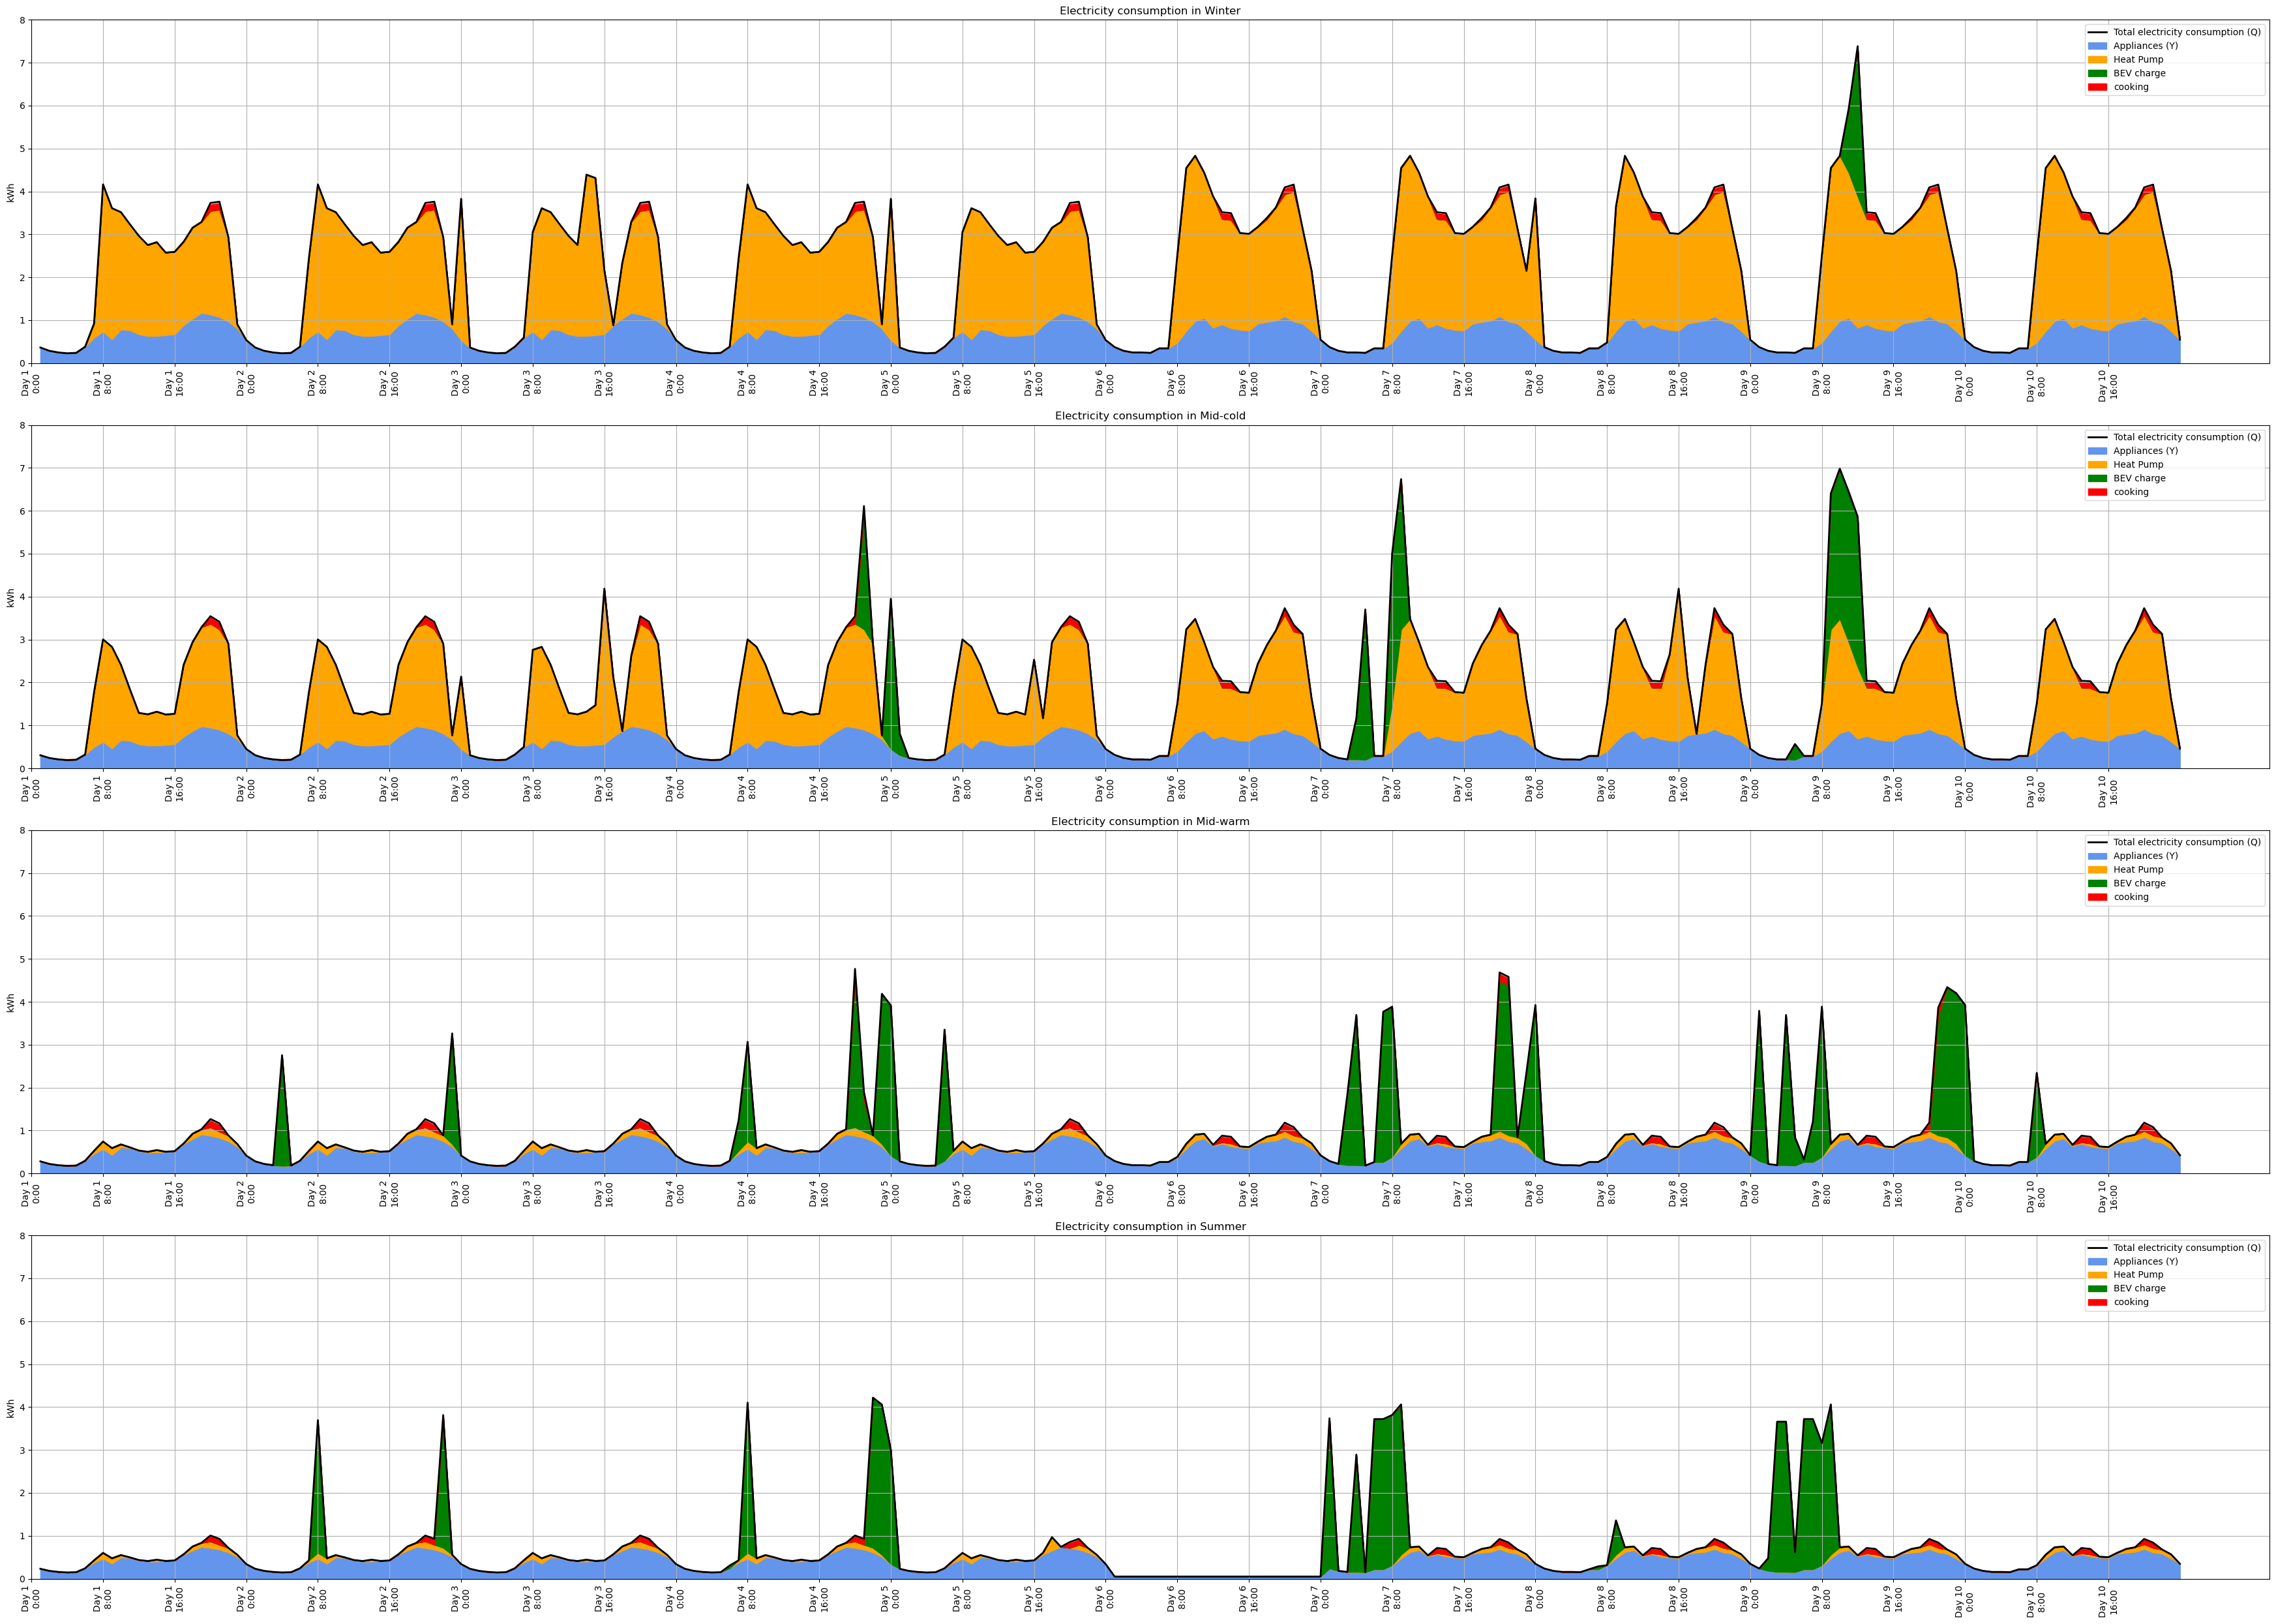

In [39]:
#Electricity consumption
plt.figure(figsize=(35, 25))
Time=range(1,241)
Time_ind=pd.Index(range(1, 241))

ore_totali = 240

# Impostiamo le etichette per le ore del giorno (0-23) ripetute per 10 giorni
day_h = np.tile(np.arange(24), 10)  # Ripeti le ore da 0 a 23 per 10 volte
# Creiamo un array per i giorni (Day 1, Day 2, ... Day 10)
day_names = np.repeat([f'Day {i+1}' for i in range(10)], 24)
# Uniamo i giorni e le ore per creare le etichette delle x
x_labels = [f'{day}\n{hour}:00' for day,hour in zip(day_names,day_h)]

# Impostiamo le etichette sull'asse delle x ogni 6 ore

for i, season in enumerate(seasons, 1):
    Q_season = Q[(Q['season'] == season) & (Q['n_names'] == 'EE')]['values']
    EE_base_season = EE_base[EE_base['season'] == season]['values']
    EE_HP_season = EE_HP[EE_HP['season'] == season]['values']
    #PV_consump_season.index=Time_ind
    EE_BEV_season = EE_BEV[EE_BEV['season'] == season]['values']
    EE_cook_season = EE_cook[EE_cook['season'] == season]['values']

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_season, color='black', linewidth=2, label='Total electricity consumption (Q)')
    plt.fill_between(Time,0,EE_base_season, color='cornflowerblue', label='Appliances (Y)')
    plt.fill_between(Time,EE_base_season,EE_base_season+EE_HP_season, color='orange', label='Heat Pump')
    plt.fill_between(Time,EE_base_season+EE_HP_season,EE_base_season+EE_HP_season+EE_BEV_season, color='green', label='BEV charge')
    plt.fill_between(Time,EE_base_season+EE_HP_season+EE_BEV_season,EE_base_season+EE_HP_season+EE_BEV_season+EE_cook_season, color='red', label='cooking')
    plt.xticks(ticks=np.arange(0, 240, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('kWh')
    plt.ylim(0,8)
    plt.xlim(0,250)
    plt.title(f'Electricity consumption in {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Electricity: supply

In [16]:
PV_prod=X[X['a_names']=='PV']
PV_sell=X[X['a_names']=='National Grid export']
Battery=X[X['a_names']=='Storing EE']
Q_EE=Q[Q['n_names']=='EE']
PV_prod.index = Q_EE.index = PV_sell.index =Battery.index = range(len(PV_prod))

Batt_charge=Battery.copy()
Batt_charge['values'] = Batt_charge['values'].apply(lambda x: 0 if x > 0 else x)

PV_consump=PV_prod.copy()
PV_consump['values']=PV_prod['values'].to_numpy()-PV_sell['values'].to_numpy()+Battery['values'].to_numpy()
PV_consump['values'] = PV_consump['values'].where(PV_prod['values']>0, 0) 
PV_consump['values'] = PV_prod['values'].where((PV_prod['values']<Q_EE['values']) & (Battery['values']>=0), PV_consump['values'])

Batt_discharge=Battery.copy()
Batt_discharge['values'] = Batt_discharge['values'].to_numpy()-PV_sell['values'].to_numpy()
Batt_discharge['values'] = Batt_discharge['values'].apply(lambda x: 0 if x < 0 else x)

EE_grid=X[X['a_names']=='National Grid import']

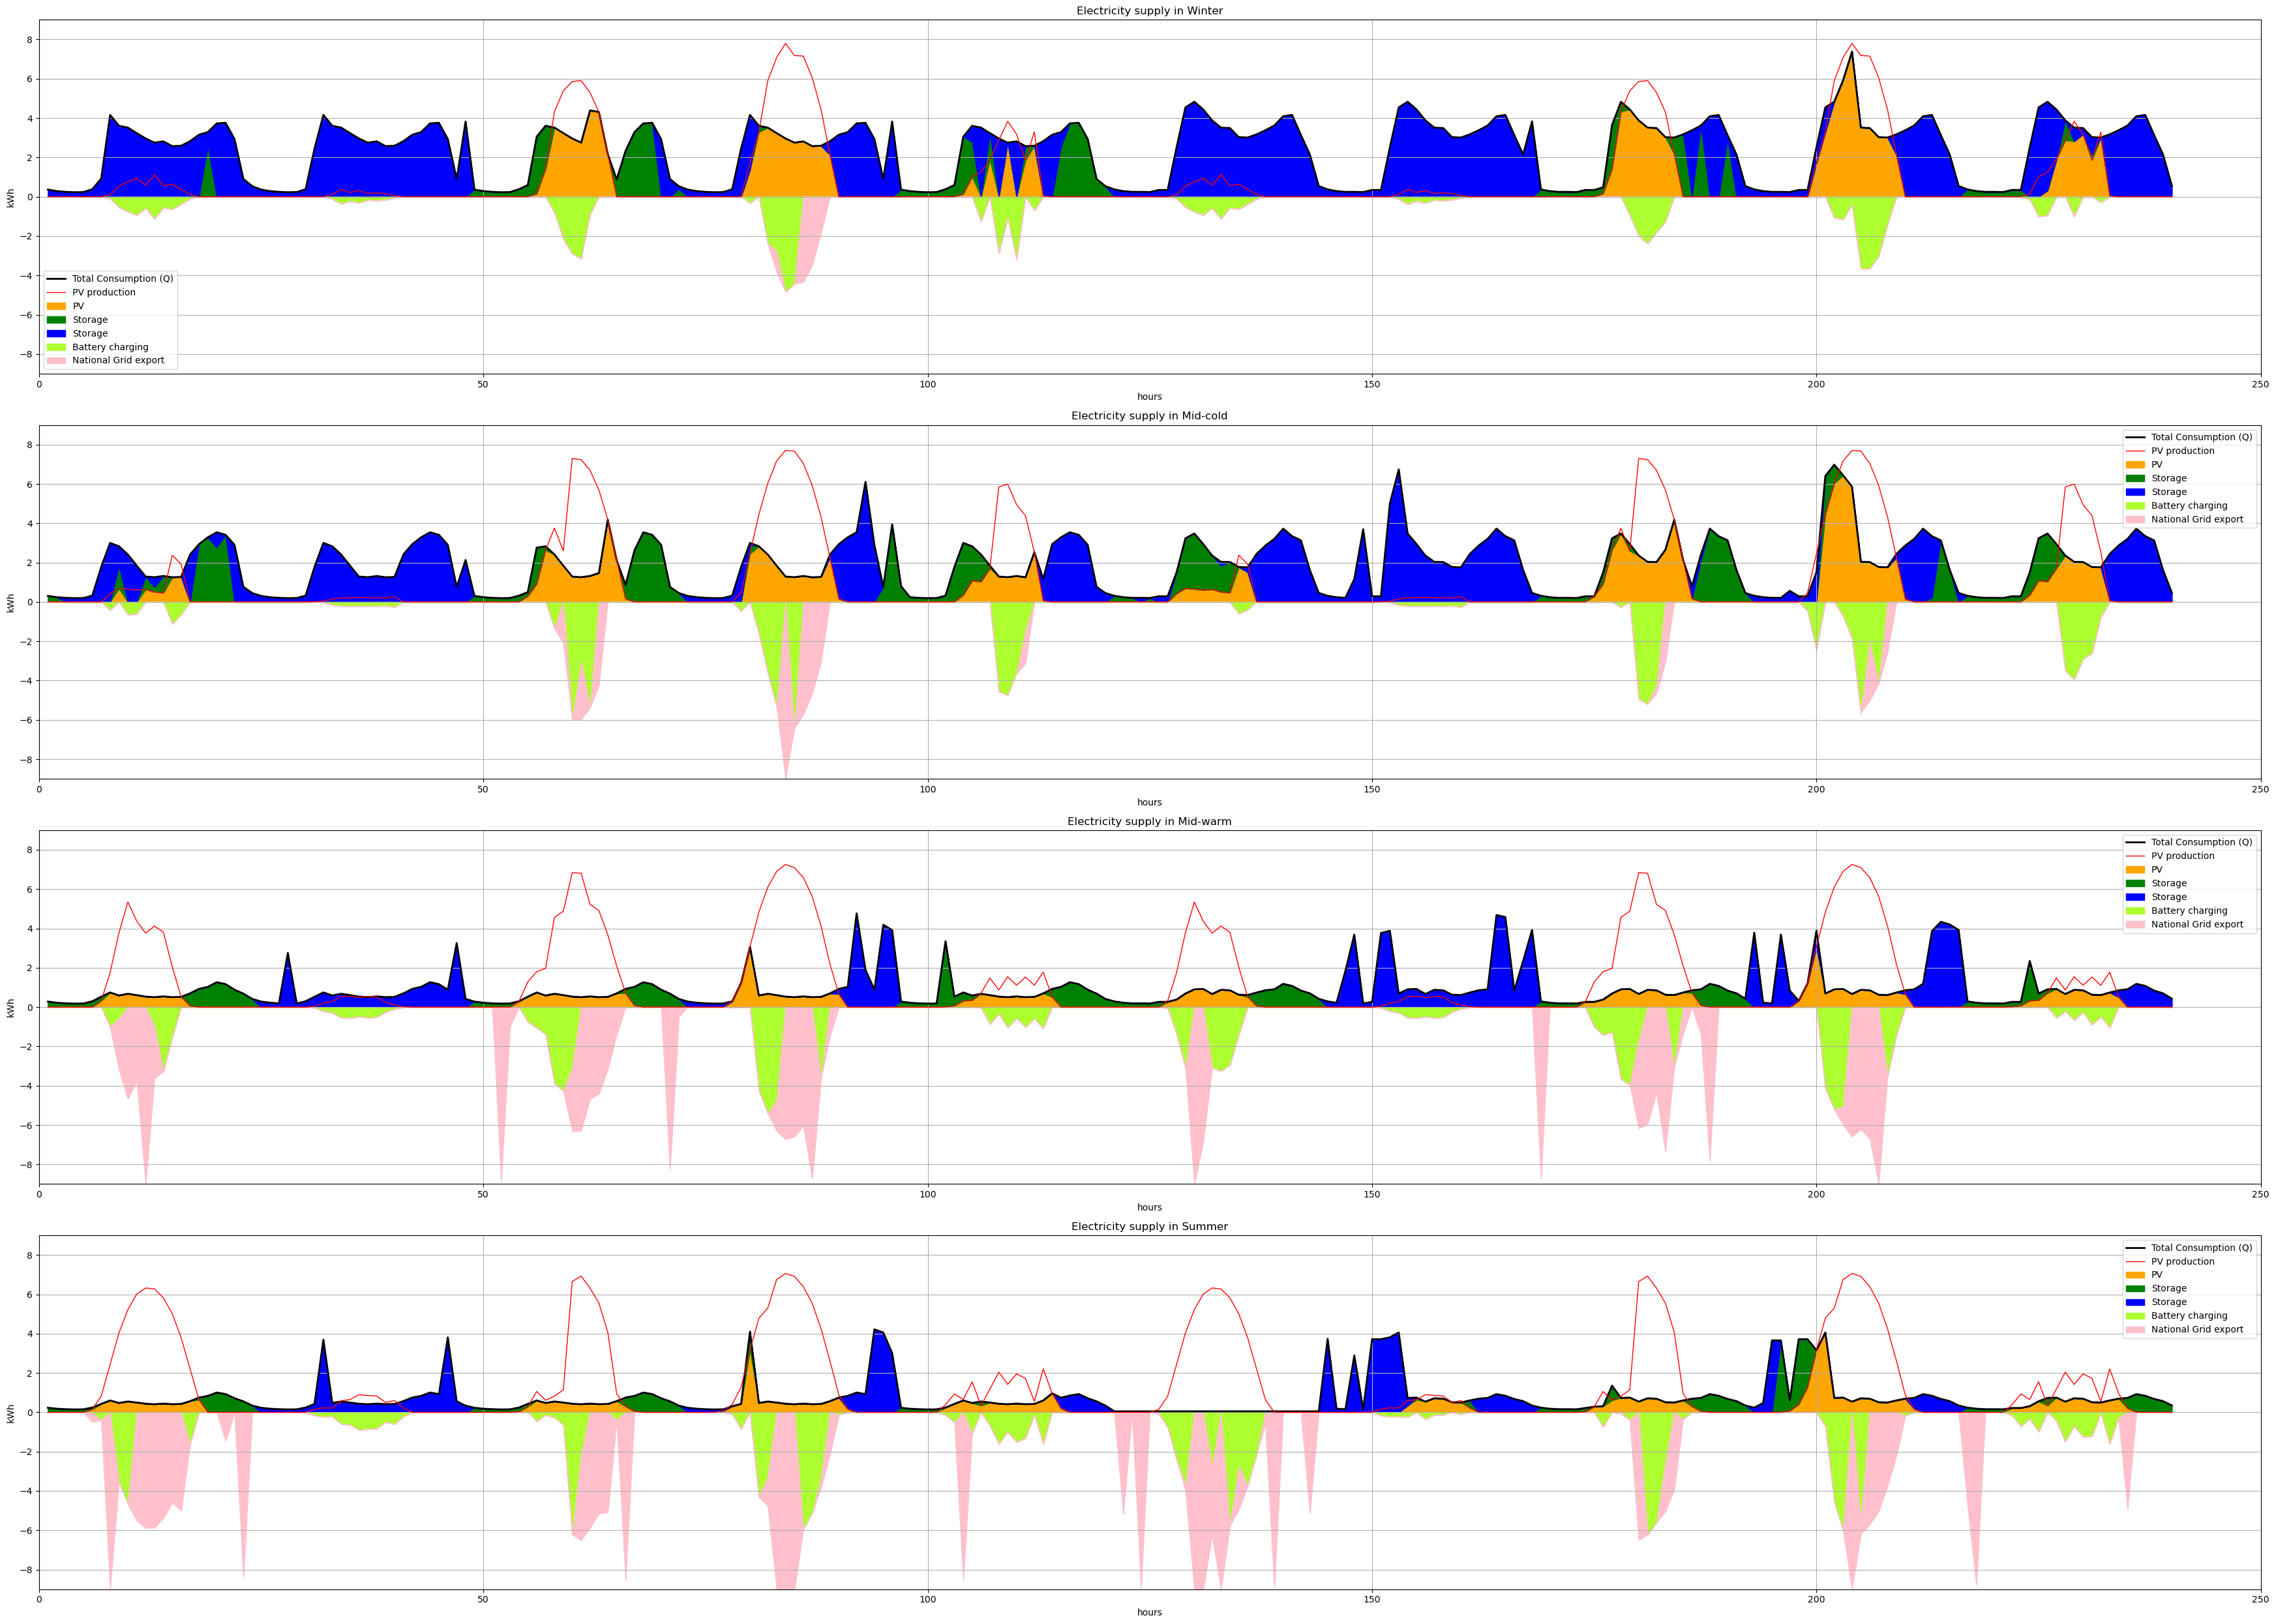

In [17]:
#Electricity production
plt.figure(figsize=(35, 25))
Time=range(1,241)
Time_ind=pd.Index(range(1, 241))
for i, season in enumerate(seasons, 1):
    Q_season = Q[(Q['season'] == season) & (Q['n_names'] == 'EE')]['values']
    PV_prod_season = PV_prod[PV_prod['season'] == season]['values']
    PV_consump_season = PV_consump[PV_consump['season'] == season]['values']
    PV_consump_season.index=Time_ind
    Batt_discharge_season = Batt_discharge[Batt_discharge['season'] == season]['values']
    Batt_discharge_season.index=Time_ind
    EE_grid_season = EE_grid[EE_grid['season'] == season]['values']
    EE_grid_season.index=Time_ind

    Batt_charge_season = Batt_charge[Batt_charge['season'] == season]['values']
    Batt_charge_season.index=Time_ind
    PV_sell_season=-PV_sell[PV_sell['season'] == season]['values']
    PV_sell_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(Time, PV_prod_season, color='red', linewidth=1, label='PV production')
    plt.fill_between(Time,0,PV_consump_season, color='orange', label='PV')
    plt.fill_between(Time,PV_consump_season,PV_consump_season+Batt_discharge_season, color='green', label='Storage')
    plt.fill_between(Time,PV_consump_season+Batt_discharge_season,PV_consump_season+Batt_discharge_season+EE_grid_season, color='blue', label='Storage')
    #negative
    plt.fill_between(Time,0,Batt_charge_season, color='greenyellow', label='Battery charging')
    plt.fill_between(Time,Batt_charge_season,Batt_charge_season+PV_sell_season, color='pink', label='National Grid export')
    plt.xticks(ticks=np.arange(0, 240, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('kWh')
    plt.ylim(-9,9)
    plt.xlim(0,250)
    plt.title(f'Electricity supply in {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Hot water

In [18]:
HP_prod=Xt[Xt['t_names']=='HP']
HW_storage=X[X['a_names']=='Storing HW']
Q_HW=Q[Q['n_names']=='Hot water']
HP_prod.index = Q_HW.index = HW_storage.index =range(len(HP_prod))

stor_charge=HW_storage.copy()
stor_charge['values'] = stor_charge['values'].apply(lambda x: 0 if x > 0 else x)
stor_discharge=HW_storage.copy()
stor_discharge['values'] = stor_discharge['values'].apply(lambda x: 0 if x < 0 else x)

HP_use=HP_prod.copy()
HP_use['values']=HP_prod['values'].to_numpy()+stor_charge['values'].to_numpy()

HW_for_heating=Q[Q['n_names']=='Heat']
HW_for_heating['values']=HW_for_heating['values']*1.2

/var/folders/7_/h7wd3zm54kg_zntp92069r1h0000gn/T/ipykernel_6873/3618342171.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HW_for_heating['values']=HW_for_heating['values']*1.2


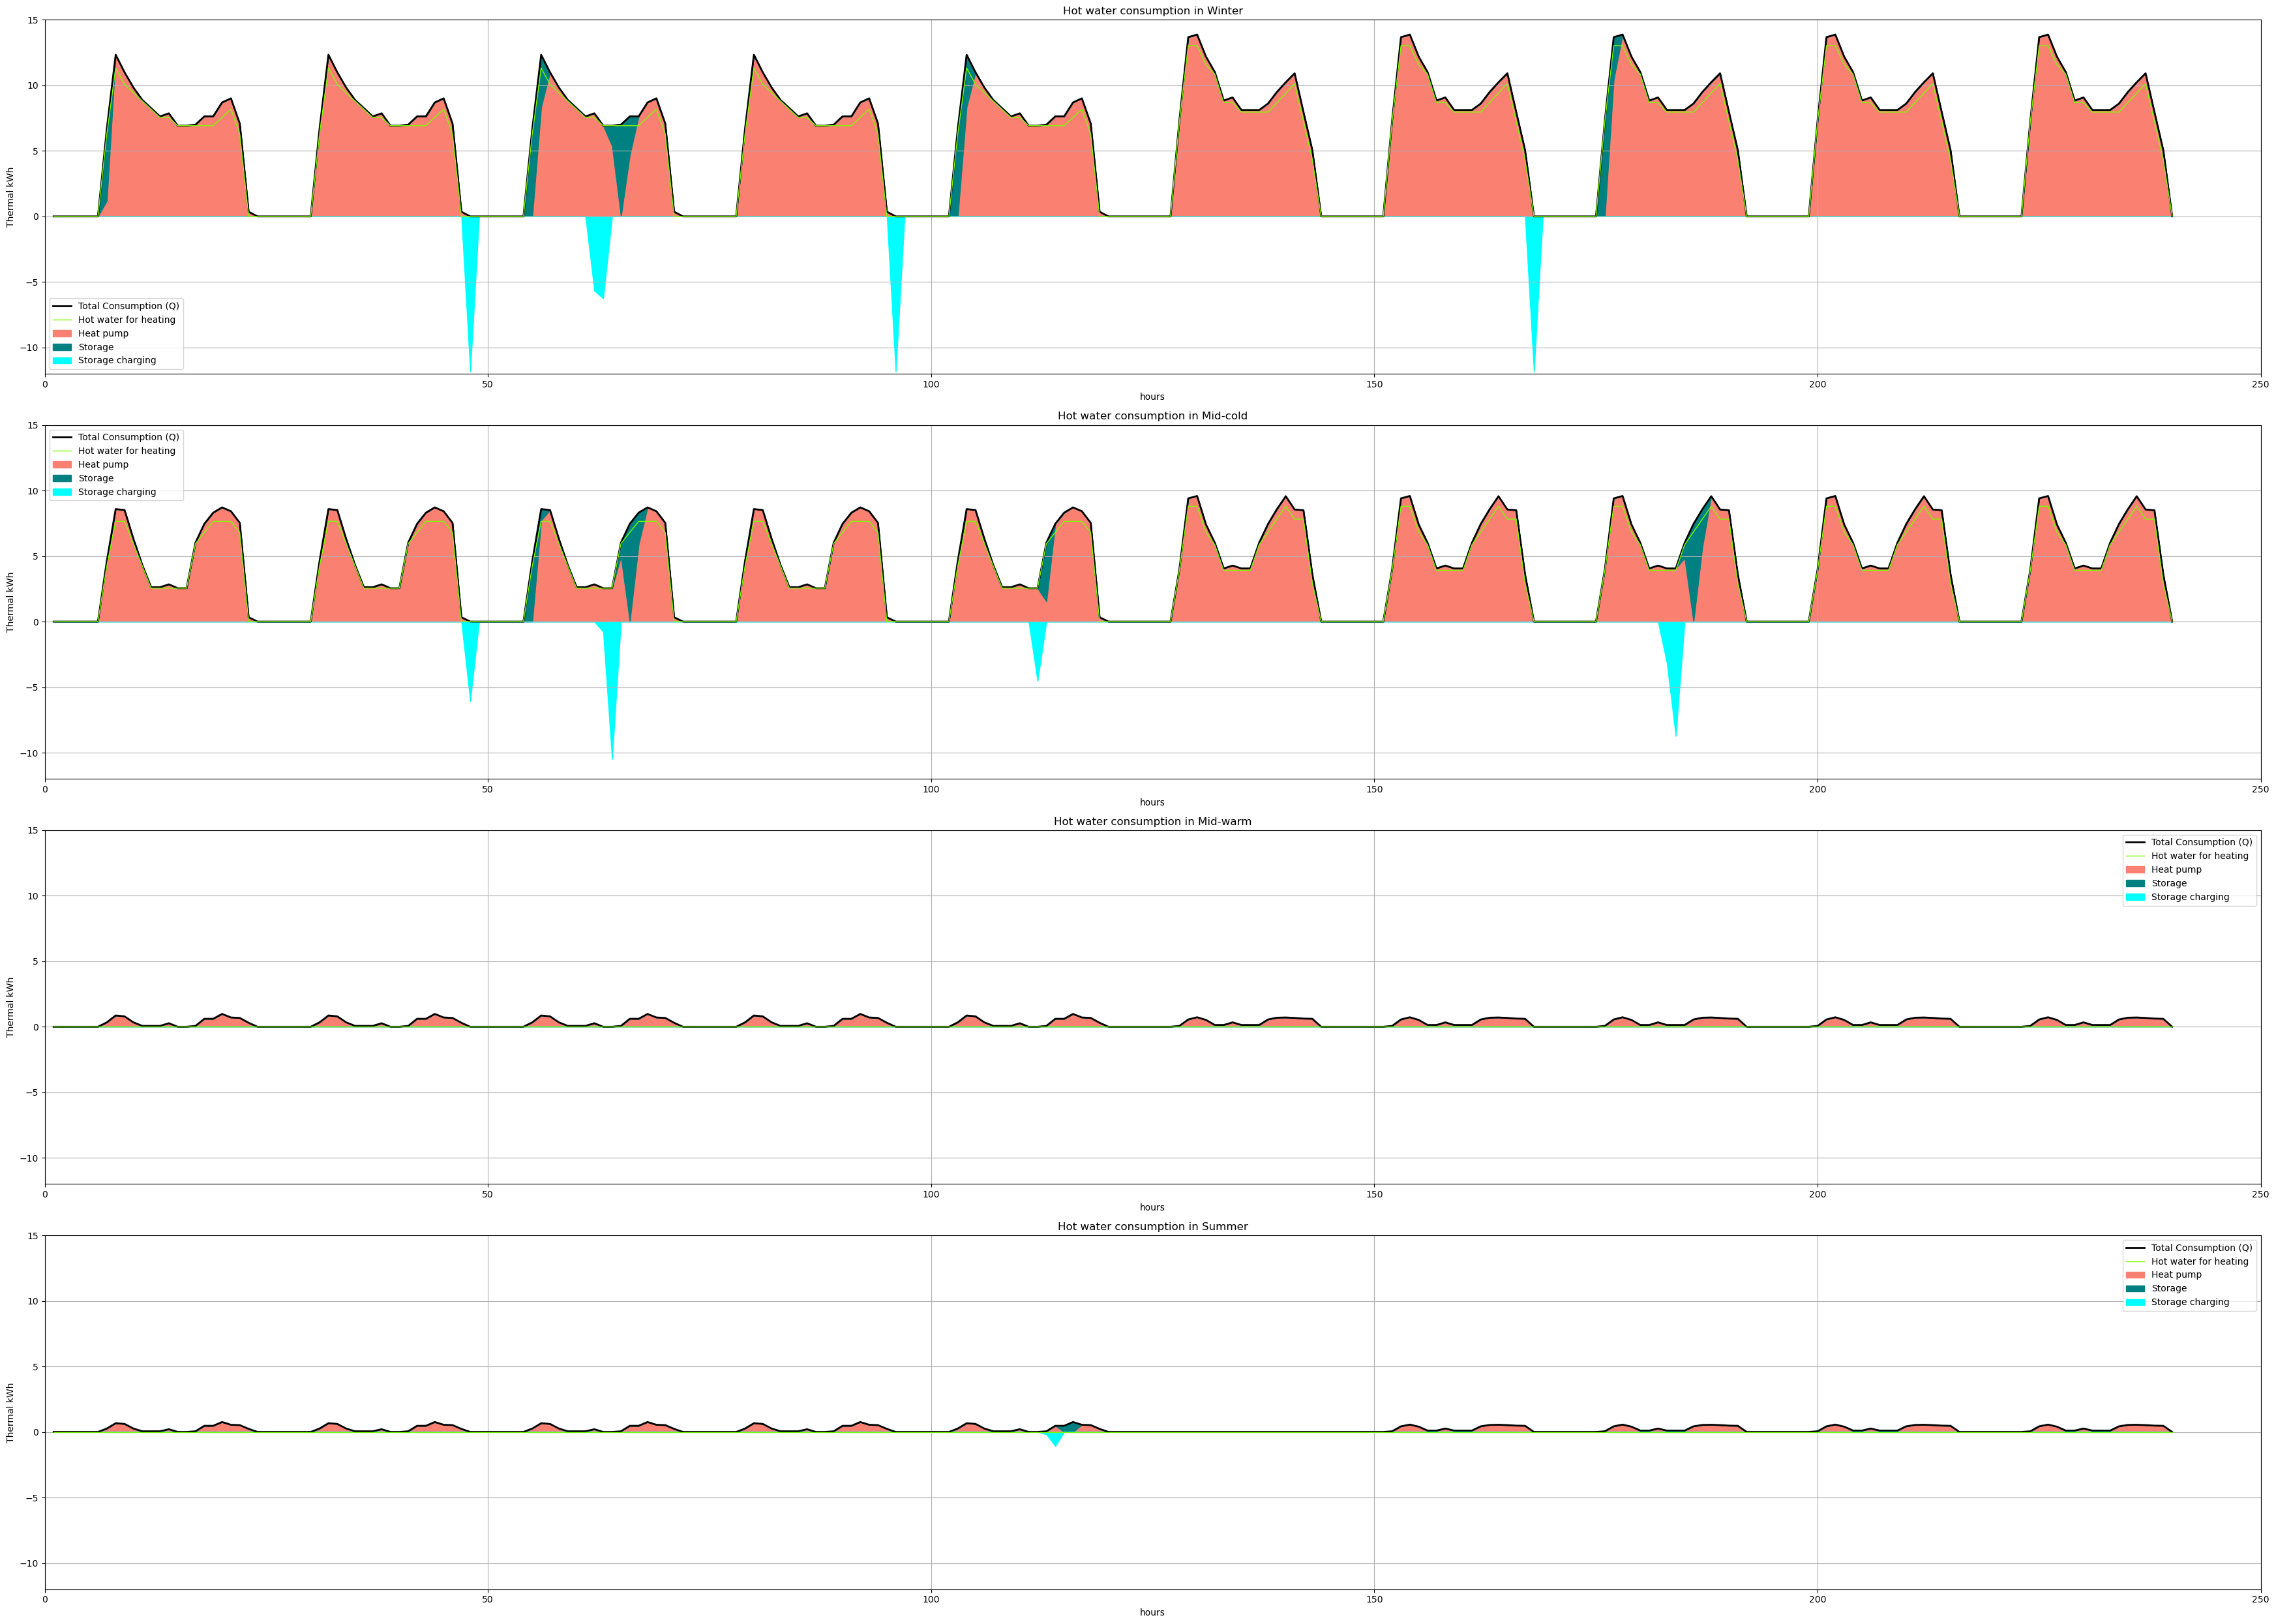

In [22]:
#Hot water production
plt.figure(figsize=(35, 25))

for i, season in enumerate(seasons, 1):
    Q_HW_season = Q[(Q['season'] == season) & (Q['n_names'] == 'Hot water')]['values']
    HP_use_season = HP_use[HP_use['season'] == season]['values']
    stor_charge_season = stor_charge[stor_charge['season'] == season]['values']
    #PV_consump_season.index=Time_ind
    stor_discharge_season = stor_discharge[stor_discharge['season'] == season]['values']
    HW_heating_season = HW_for_heating[HW_for_heating['season'] == season]['values']

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_HW_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(Time, HW_heating_season, color='lawngreen', linewidth=1, label='Hot water for heating')
    plt.fill_between(Time,0,HP_use_season, color='salmon', label='Heat pump')
    plt.fill_between(Time,HP_use_season,HP_use_season+stor_discharge_season, color='teal', label='Storage')
    #negative
    plt.fill_between(Time,0,stor_charge_season, color='cyan', label='Storage charging')
    plt.xticks(ticks=np.arange(0, 240, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('Thermal kWh')
    plt.ylim(-12,15)
    plt.xlim(0,250)
    plt.title(f'Hot water consumption in {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Heating?

Cooking

In [24]:
Gas_stove=X[X['a_names']=='Gas stove cooking']
Ind_stove=X[X['a_names']=='Induction stove cooking']
Gas_stove.index = Ind_stove.index =range(len(Gas_stove))

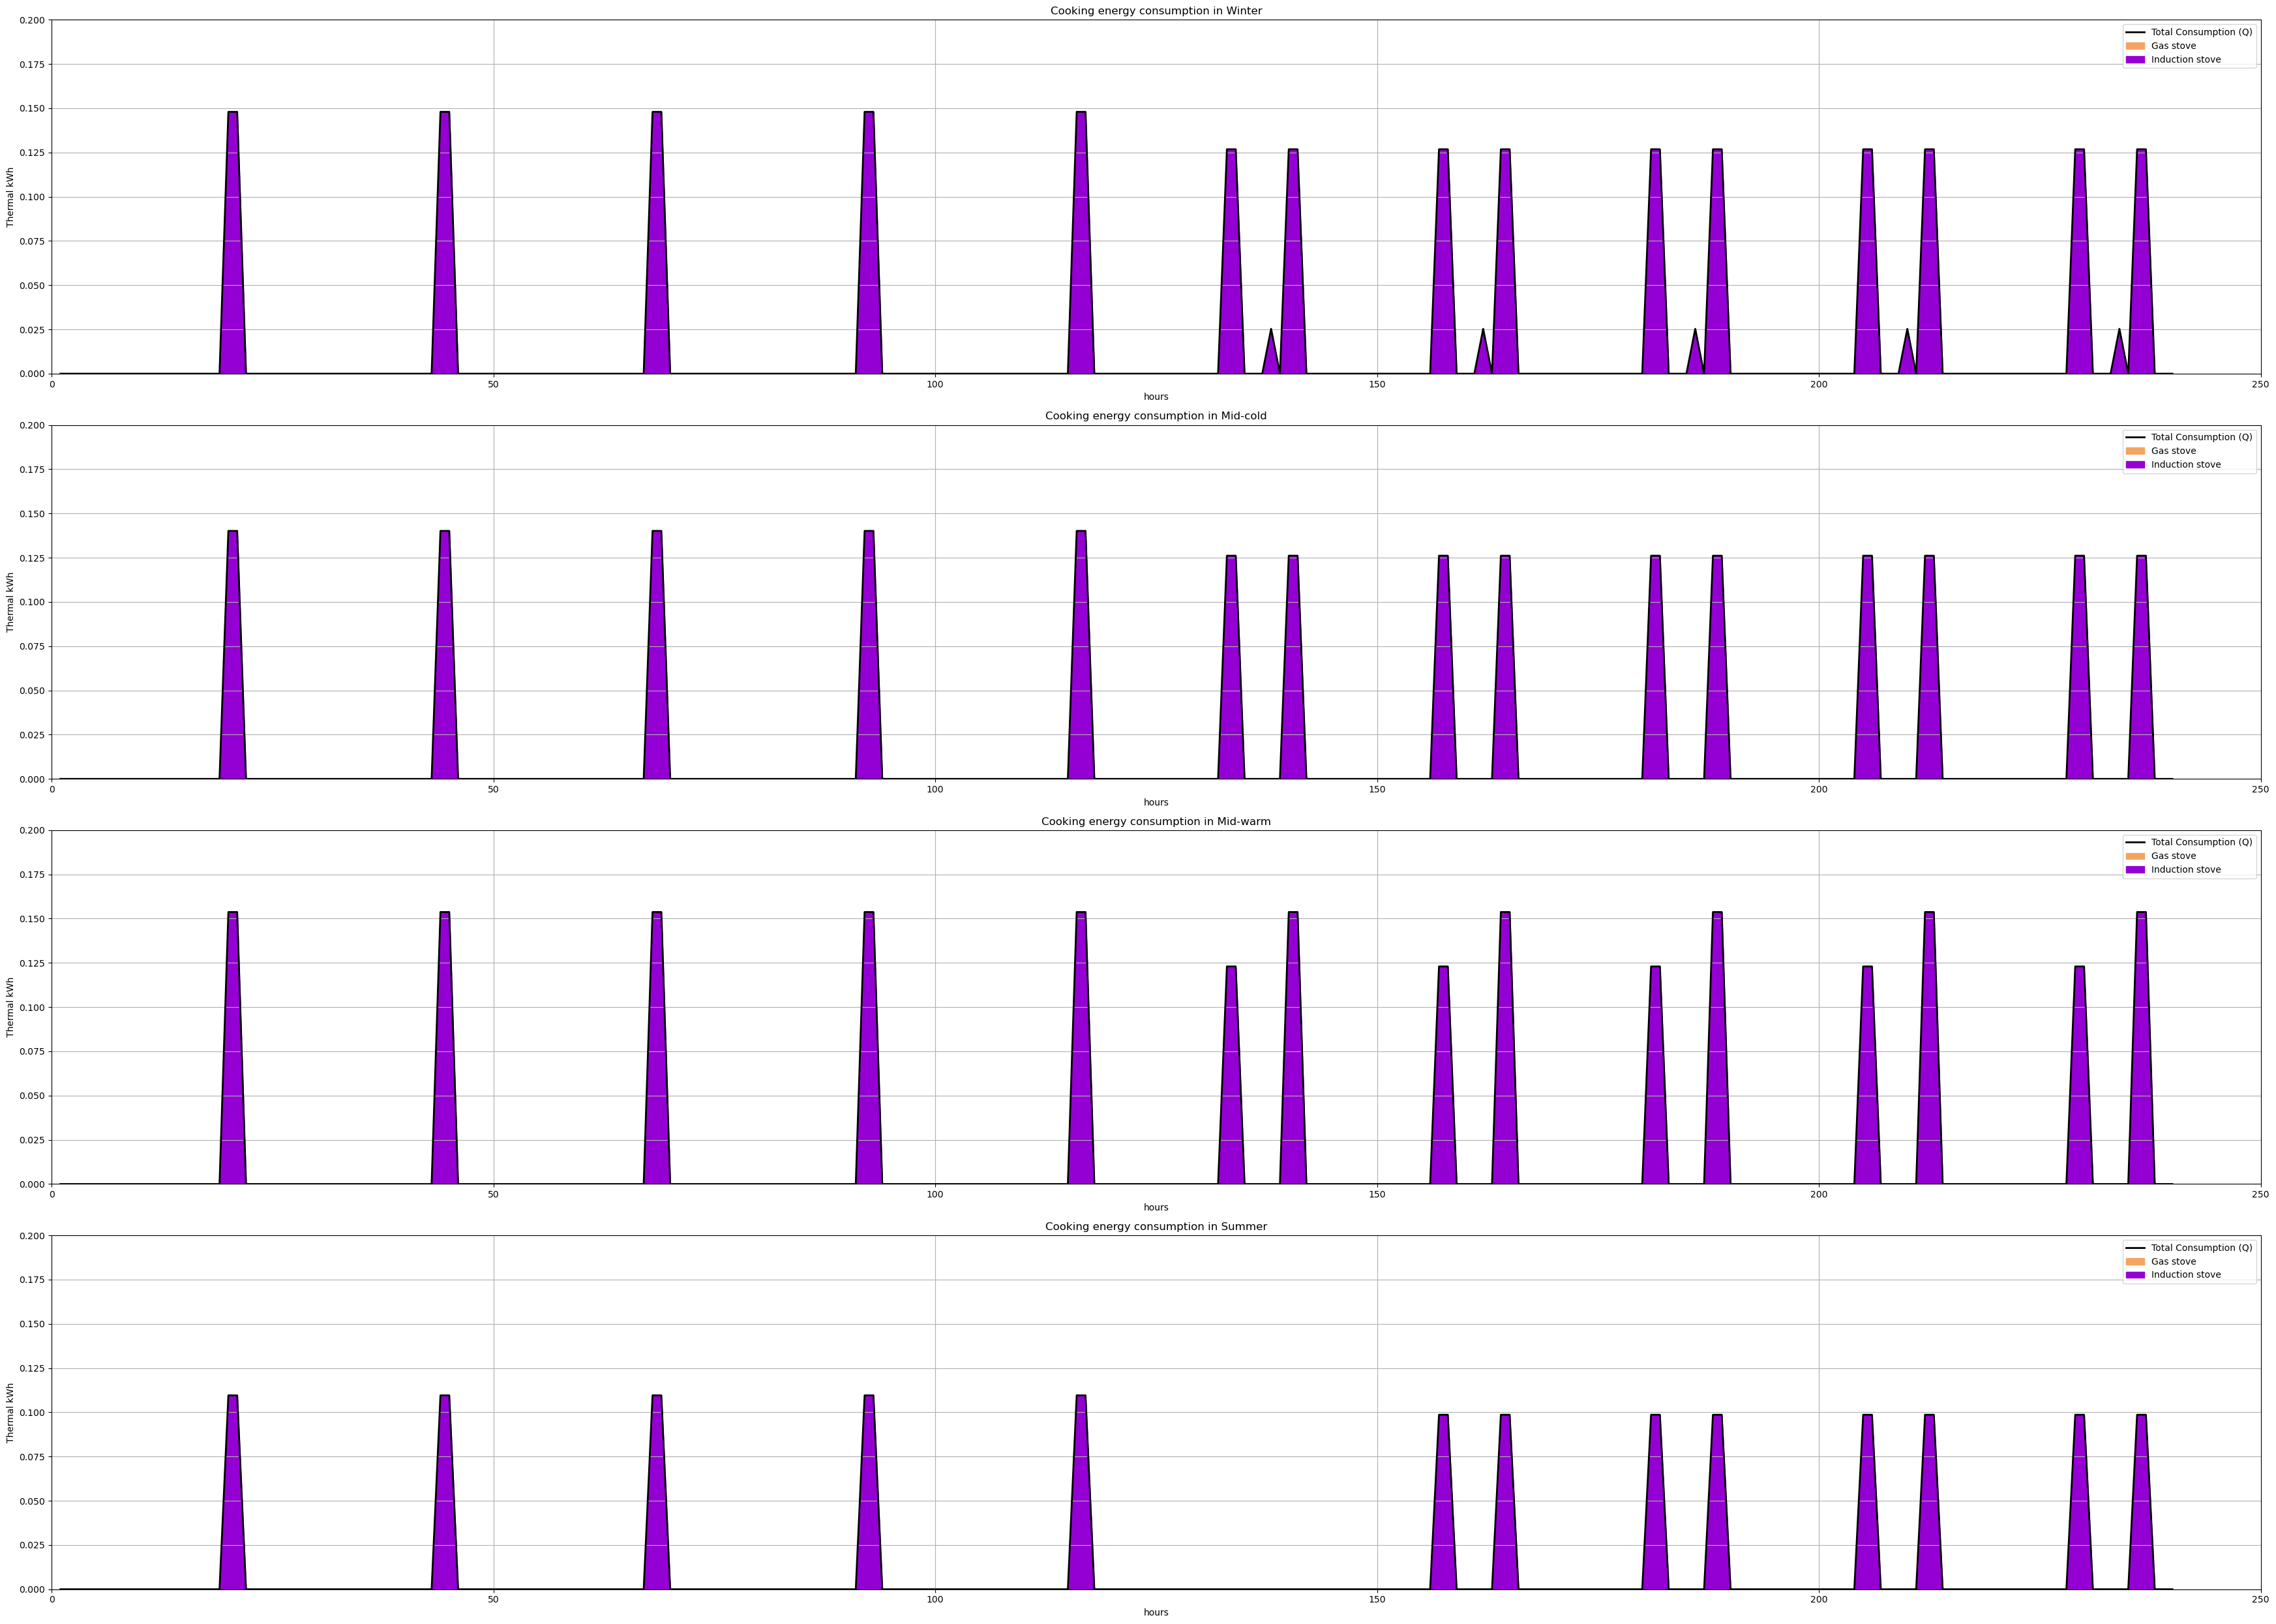

In [25]:
#Cooking consumption
plt.figure(figsize=(35, 25))

for i, season in enumerate(seasons, 1):
    Q_cook_season = Q[(Q['season'] == season) & (Q['n_names'] == 'Cooking')]['values']
    Gas_stove_season = Gas_stove[Gas_stove['season'] == season]['values']
    Ind_stove_season = Ind_stove[Ind_stove['season'] == season]['values']
    #PV_consump_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_cook_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.fill_between(Time,0,Gas_stove_season, color='sandybrown', label='Gas stove')
    plt.fill_between(Time,0,Ind_stove_season, color='darkviolet', label='Induction stove')
    #negative
    plt.xticks(ticks=np.arange(0, 240, 8), labels=x_labels[::8], rotation=90)
    plt.ylabel('Thermal kWh')
    plt.ylim(0,0.2)
    plt.xlim(0,250)
    plt.title(f'Cooking energy consumption in {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Transport

In [27]:
BEV_urban=X[X['a_names']=='BEV urban']
BEV_mot=X[X['a_names']=='BEV motorway']
Charge_home=X[X['a_names']=='BEV charging home']
Charge_street1=X[X['a_names']=='BEV charging1 street']
Charge_street2=X[X['a_names']=='BEV charging2 street']
BEV_urban.index = BEV_mot.index =Charge_home.index=Charge_street1.index=Charge_street2.index = range(len(BEV_urban))

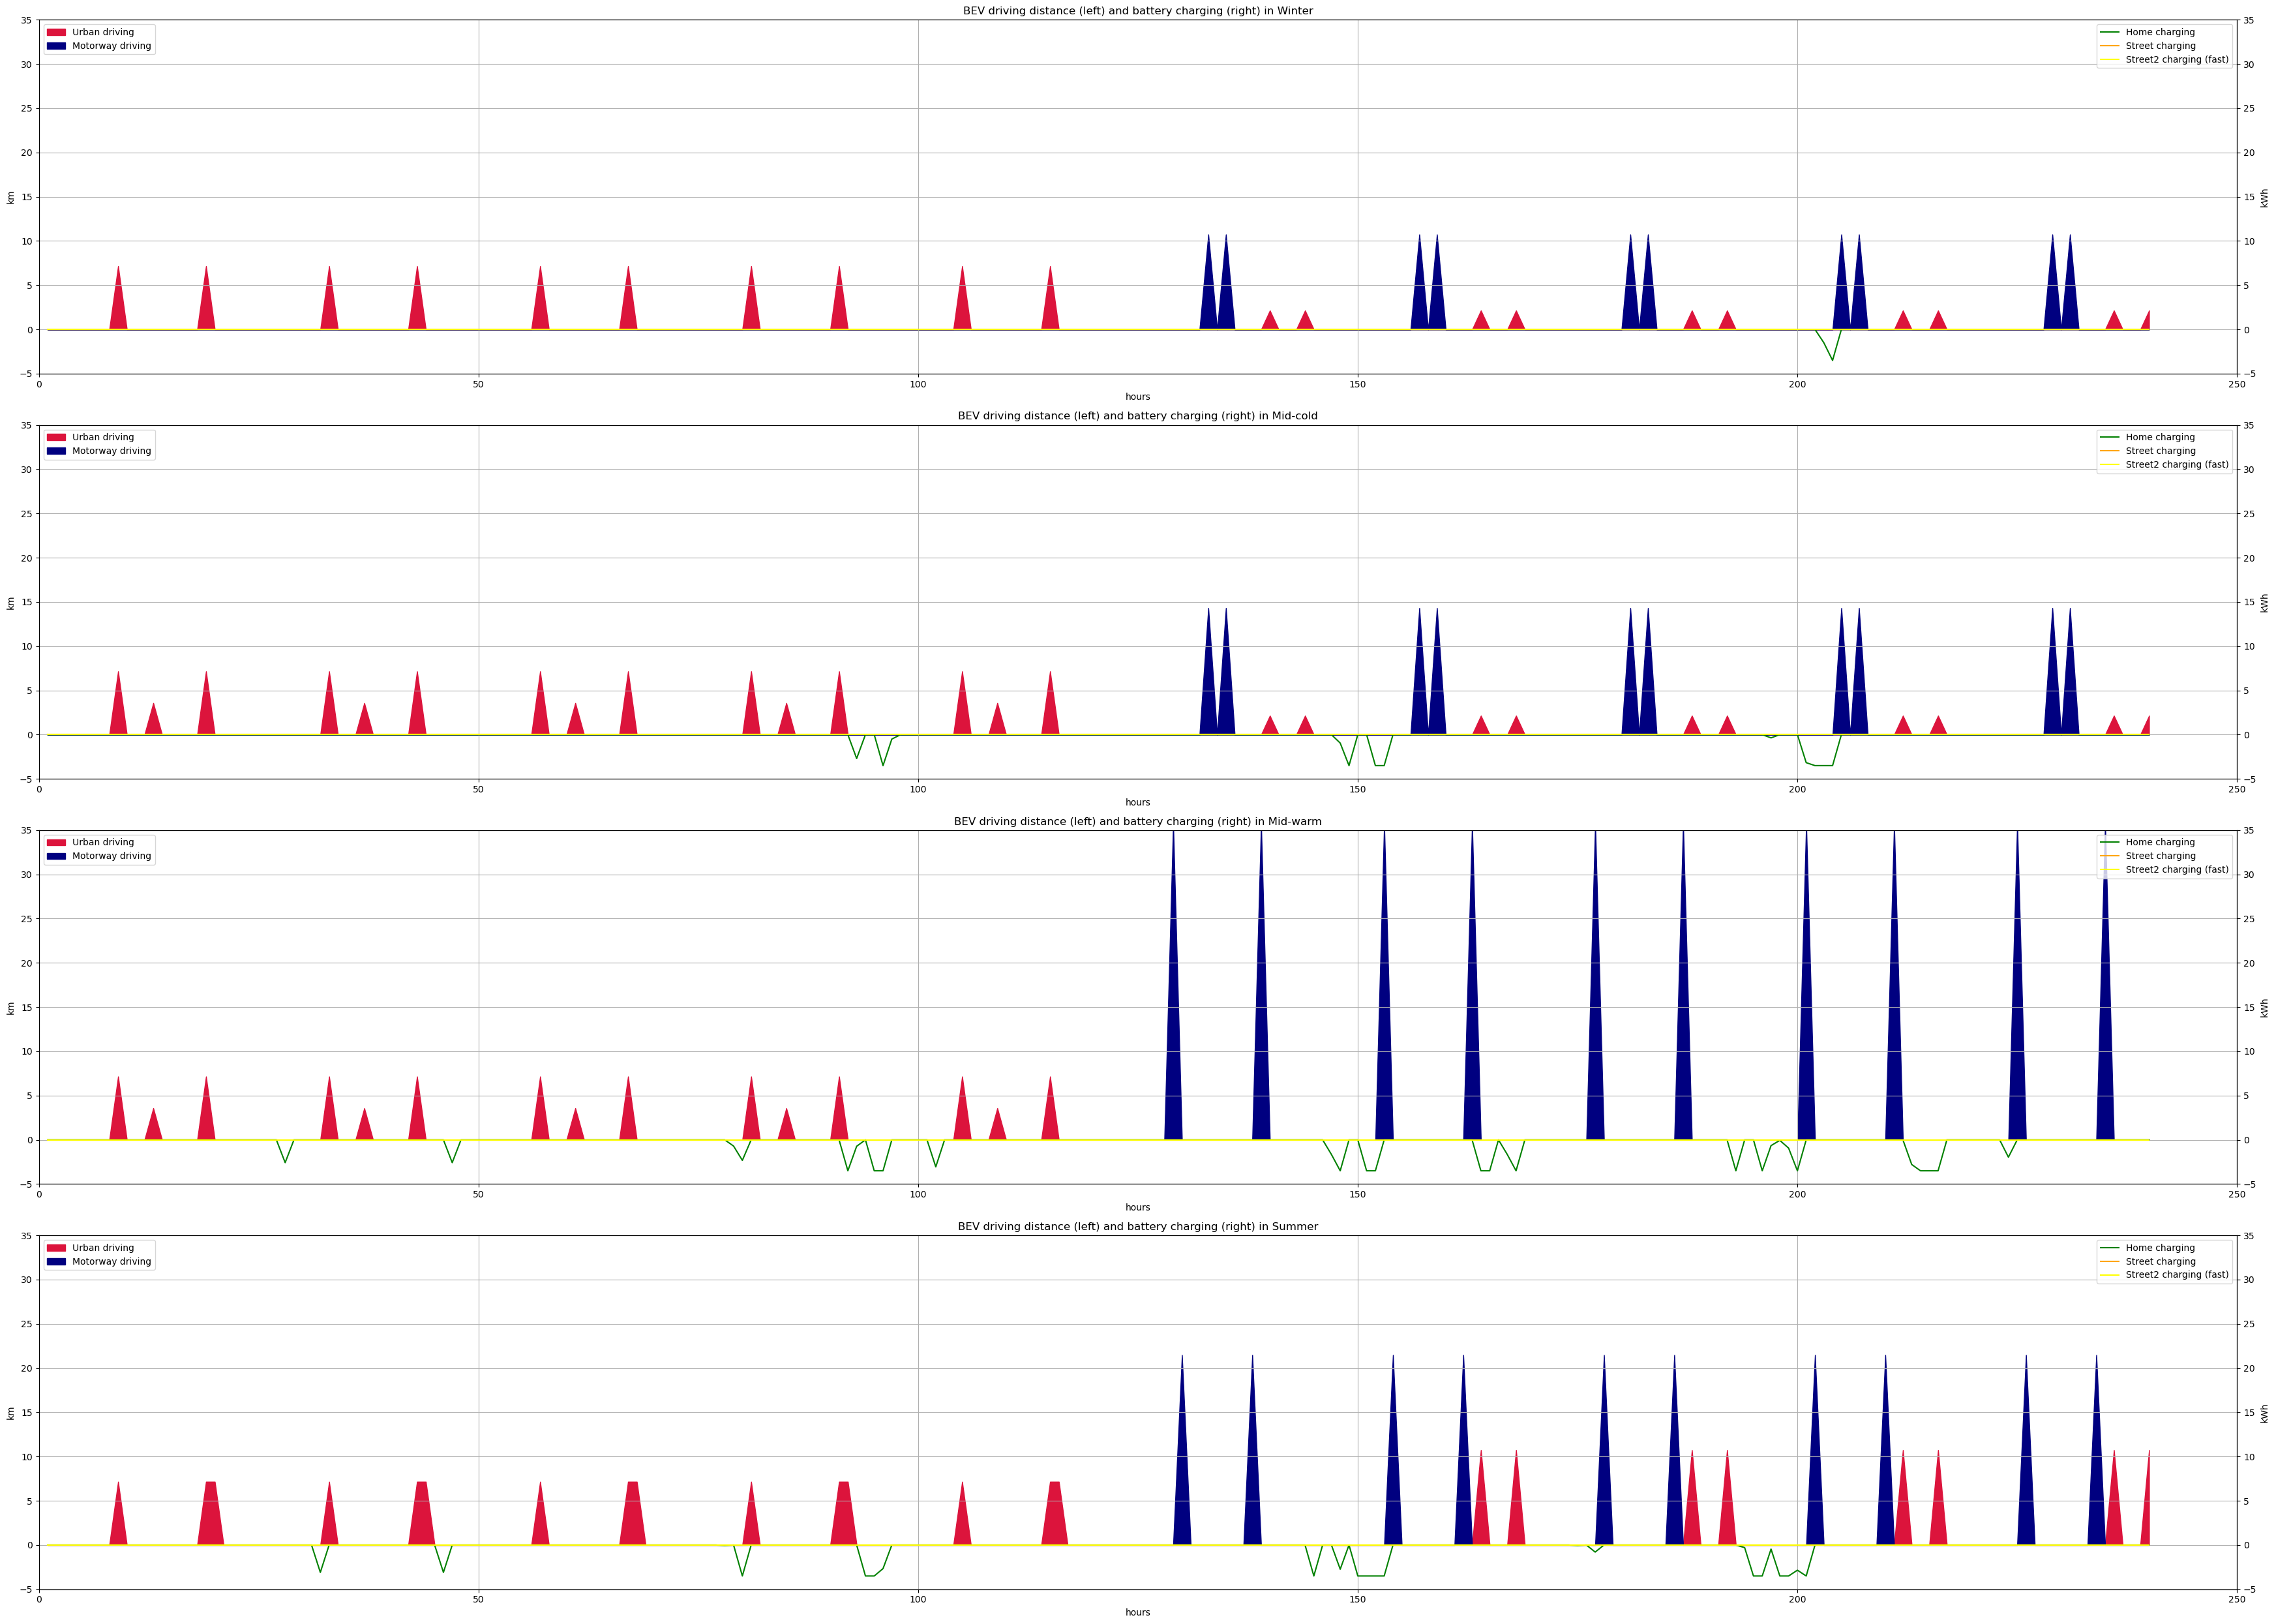

In [33]:
plt.figure(figsize=(35, 25))

for i, season in enumerate(seasons, 1):
    BEV_urban_season = BEV_urban[BEV_urban['season'] == season]['values']
    BEV_mot_season = BEV_mot[BEV_mot['season'] == season]['values']
    Charge_home_season = -Charge_home[Charge_home['season'] == season]['values']
    Charge_street1_season = -Charge_street1[Charge_street1['season'] == season]['values']
    Charge_street2_season = -Charge_street2[Charge_street2['season'] == season]['values']

    ax1=plt.subplot(4, 1, i)
    ax1.fill_between(Time,0,BEV_urban_season, color='crimson', label='Urban driving')   
    ax1.fill_between(Time,0,BEV_mot_season, color='navy', label='Motorway driving')
    plt.xticks(ticks=np.arange(0, 240, 8), labels=x_labels[::8], rotation=90)
    ax1.set_ylabel('km')
    ax1.set_ylim(-5,35)
    ax1.set_title(f'BEV driving distance (left) and battery charging (right) in {season_names[season]}')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    #Right axis for charge
    ax2 = ax1.twinx()
    ax2.plot(Time,Charge_home_season, color='green', label='Home charging')
    ax2.plot(Time,Charge_street1_season, color='orange', label='Street charging')
    ax2.plot(Time,Charge_street2_season, color='yellow', label='Street2 charging (fast)')
    ax2.set_ylabel('kWh')
    ax2.set_ylim(-5,35)
    plt.xlim(0,250)
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Peak hour analysis

In [45]:
#Under development
peak=pd.DataFrame()
peak['tech']=peak_Q['n_names']
peak['Q']=np.zeros(len(peak['tech']))
for tech in peak['tech']:
    peak.loc[peak['tech']==tech,'Q']=peak_Q[peak_Q['n_names']==tech]['values'].values[0]

peak['Y']=np.zeros(len(peak['tech']))
for tech in peak['tech']:
    peak.loc[peak['tech']==tech,'Y']=peak_Y[peak_Y['n_names']==tech]['values'].values[0]

peak['NatGrid']=np.zeros(len(peak['tech']))
peak.loc[peak['tech']=='EE','NatGrid']=peak_X[peak_X['a_names']=='National Grid import']['values'].values[0]
peak.loc[peak['tech']=='EE','NatGrid']=1

peak['HP']=np.zeros(len(peak['tech']))
peak.loc[peak['tech']=='Hot water','HP']=peak_X[peak_X['a_names']=='HP heating winter']['values'].values[0]

peak['HW storage']=np.zeros(len(peak['tech']))
peak.loc[peak['tech']=='Hot water','HW storage']=peak_X[peak_X['a_names']=='Storing HW']['values'].values[0]
peak.loc[peak['tech']=='Hot water','HW storage']=2

peak['Heating']=np.zeros(len(peak['tech']))
peak.loc[peak['tech']=='Heat','HP']=peak_X[peak_X['a_names']=='Radiators heater']['values'].values[0]

peak['BEV charge']=np.zeros(len(peak['tech']))
peak.loc[peak['tech']=='BEV battery discharge','BEV charge']=peak_X[peak_X['a_names']=='BEV charging home']['values'].values[0]




In [62]:
#Dictionary for peak hour  EE
peak_EE = {
    "Demand": [],  # Valori per le attività che compongono la demand
    "Supply": []   # Valori per le attività che compongono la supply
}
#National grid import
peak_EE["Demand"].append(0)
peak_EE["Supply"].append(3)
#peak_EE["Supply"].append(peak_X[peak_X['a_names']=='National Grid import']['values'].values[0])

#EE appliances
peak_EE["Demand"].append(1)
#peak_EE["Demand"].append(peak_Y[peak_Y['n_names']=='EE']['values'].values[0])
peak_EE["Supply"].append(0)

#HP
peak_EE["Demand"].append(1)
#peak_EE["Demand"].append(peak_X[peak_X['a_names']=='HP heating winter']['values'].values[0]/3.6)
peak_EE["Supply"].append(0)

#Cooking
peak_EE["Demand"].append(1)
#peak_EE["Demand"].append(peak_X[peak_X['a_names']=='Induction stove cooking']['values'].values[0])
peak_EE["Supply"].append(0)


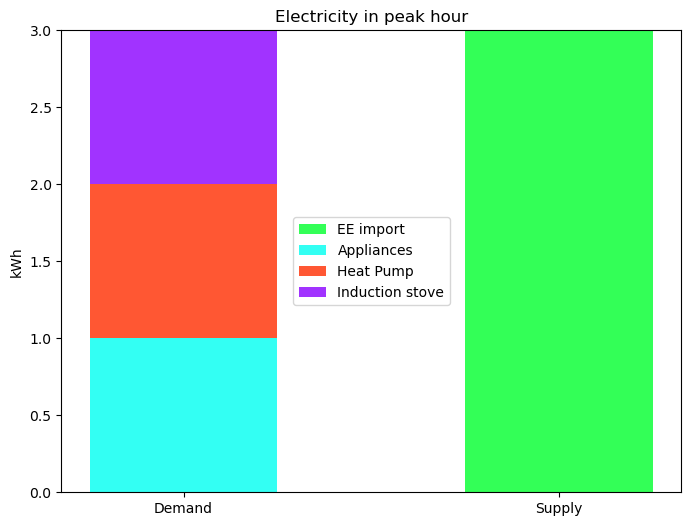

In [63]:
activities = ['EE import', 'Appliances', 'Heat Pump','Induction stove']
#activities = ['EE import', 'Appliances', 'Heat Pump','Heating','Hot water storage','Induction stove']
colors = ['#33FF57',  # Verde brillante
          '#33FFF3',  # Turchese chiaro
          '#FF5733',  # Rosso aranciato
          '#A133FF']  # Viola acceso

# Posizioni delle barre (una per Demand e una per Supply)
bar_width = 0.5
positions = np.arange(len(peak_EE))

# Creiamo il grafico
plt.figure(figsize=(8, 6))

# Variabile per tracciare la parte inferiore della barra (per la funzione bottom)
bottoms = np.zeros(len(peak_EE))

# Per ogni attività, impiliamo i dati sulle barre
for i, activity in enumerate(activities):
    values = [peak_EE[key][i] for key in peak_EE.keys()]  # Estraiamo i valori per Demand e Supply
    plt.bar(positions, values, color=colors[i], width=bar_width, bottom=bottoms, label=activity)
    bottoms += values  # Aggiorniamo i valori di bottom per la prossima attività

# Aggiungiamo le etichette delle barre (Demand e Supply)
plt.xticks(positions, peak_EE.keys())
plt.ylabel('kWh')
plt.title('Electricity in peak hour')

# Aggiungiamo una legenda per le attività
plt.legend(loc='center')

# Mostriamo il grafico
plt.show()

In [58]:
#Dictionary for peak hour Heat
peak_HW = {
    "Demand": [],  # Valori per le attività che compongono la demand
    "Supply": []   # Valori per le attività che compongono la supply
}
#HP
peak_HW["Demand"].append(0)
peak_HW["Supply"].append(2)
#peak_HW["Supply"].append(peak_X[peak_X['a_names']=='HP heating winter']['values'].values[0])

#Heating
peak_HW["Demand"].append(1)
#peak_HW["Demand"].append(peak_Y[peak_Y['n_names']=='Heat']['values'].values[0]*1.2)
peak_HW["Supply"].append(0)

#Hot water
peak_HW["Demand"].append(1)
#peak_HW["Demand"].append(peak_Y[peak_Y['a_names']=='Hot water']['values'].values[0])
peak_HW["Supply"].append(0)

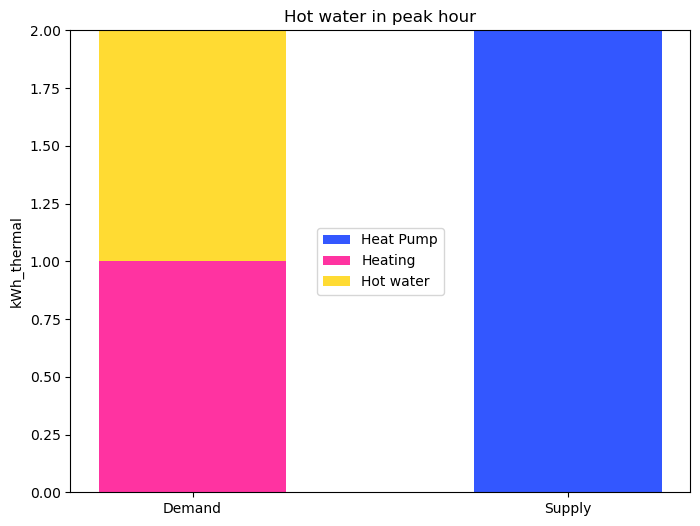

In [60]:
activities = ['Heat Pump','Heating','Hot water']
colors = ['#3357FF',  # Blu vivido
          '#FF33A1',  # Rosa acceso
          '#FFDB33',  # Giallo oro
          ] 


# Posizioni delle barre (una per Demand e una per Supply)
bar_width = 0.5
positions = np.arange(len(peak_EE))

# Creiamo il grafico
plt.figure(figsize=(8, 6))

# Variabile per tracciare la parte inferiore della barra (per la funzione bottom)
bottoms = np.zeros(len(peak_EE))

# Per ogni attività, impiliamo i dati sulle barre
for i, activity in enumerate(activities):
    values = [peak_HW[key][i] for key in peak_HW.keys()]  # Estraiamo i valori per Demand e Supply
    plt.bar(positions, values, color=colors[i], width=bar_width, bottom=bottoms, label=activity)
    bottoms += values  # Aggiorniamo i valori di bottom per la prossima attività

# Aggiungiamo le etichette delle barre (Demand e Supply)
plt.xticks(positions, peak_HW.keys())
plt.ylabel('kWh_thermal')
plt.title('Hot water in peak hour')

# Aggiungiamo una legenda per le attività
plt.legend(loc='center')

# Mostriamo il grafico
plt.show()

Export from database to excel

In [ ]:
Y_summer=Y[Y['season']=='su']
Y_summer.to_excel('excel database/Y_summer.xlsx')
Q_summer=Q[Q['season']=='su']
Q_summer.to_excel('excel database/Q_summer.xlsx')
X_summer=X[X['season']=='su']
X_summer.to_excel('excel database/X_summer.xlsx')

In [ ]:
#Codice potenzialmente utile
plt.figure(figsize=(25, 10))
Time=range(1, 961)

plt.plot(Time, Q_EE['values'], color='black', linewidth=2, label='Total Consumption (Q)')
plt.plot(Time, PV_prod['values'], color='green', linewidth=2, label='PV Production')
plt.plot(Time, PV_consump['values'], color='orange', linewidth=2, label='PV Consumption')
plt.ylim(-9,9)
plt.title(f'Electricity consumption in {season_names[season]}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()